In [1]:
import shutil
from pathlib import Path
import numpy as np 
import pandas as pd
import imageio.v3 as iio
import matplotlib.pyplot as plt

import zipfile
from tqdm.notebook import tqdm

from numpy.lib.stride_tricks import sliding_window_view
from mpl_toolkits.axes_grid1 import ImageGrid

from datasets.urban_footprint_extraction import (
    transformation_strategy_cityosm,
    transformation_strategy_inria,
    transformation_strategy_potsdam,
    transformation_strategy_vaihingen
)

In [2]:
DATA = Path.home() / "datasets" / "urban-footprint"
IMAGE_DIR = DATA / "images"
IMAGE_DIR.mkdir(parents=True, exist_ok=True)
MASK_DIR = DATA / "masks"
MASK_DIR.mkdir(parents=True, exist_ok=True)

DATASET_ZIPFILES = ("berlin", "paris", "zurich", "tokyo", "chicago", "inria", "vaihingen", "potsdam")

TILED_IMAGE_DIR = DATA / "images_tiled"
TILED_IMAGE_DIR.mkdir(parents=True, exist_ok=True)
TILED_MASK_DIR = DATA / "masks_tiled"
TILED_MASK_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# TODO: Decide Train Val Test Split From Each Location
# TODO: Convert Mask to Map using Projection and CRS

In [4]:
def extract(dataset_zip_path: Path):
    dataset_name = dataset_zip_path.stem
    if dataset_name in ("berlin", "paris", "zurich", "tokyo", "chicago"):
        transformation_strategy_cityosm(dataset_zip_path, IMAGE_DIR, MASK_DIR)
    elif dataset_name == "inria":
        transformation_strategy_inria(dataset_zip_path, IMAGE_DIR, MASK_DIR)
    elif dataset_name == "vaihingen":
        transformation_strategy_vaihingen(dataset_zip_path, IMAGE_DIR, MASK_DIR)
    elif dataset_name == "potsdam":
        transformation_strategy_potsdam(dataset_zip_path, IMAGE_DIR, MASK_DIR)

#for dataset in tqdm(DATASET_ZIPFILES, desc = "Overall Progress"):
    #extract(DATA / "archive" / f"{dataset}.zip") 

In [5]:
def get_tiled_view(image: np.ndarray, kernel: tuple[int, int, int]):
    """
    Return a non-overlapping sliding window view of image 

    image.shape: (height, width, num_channels)
    kernel.shape: (kernel_height, kernel_width, num_kernel_channels) 

    return.shape (#Tiles, K_H, K_W, K_C)
    """
    return (
        sliding_window_view(image, kernel[:2], (0,1)) #type: ignore
        [::kernel[0], ::kernel[1]]
        .reshape(-1, kernel[2], kernel[0], kernel[1])
        .transpose(0, 2, 3, 1)
        .squeeze()
    )

In [6]:
def tile_dataset(tile: tuple[int,int]):
    filenames = sorted([f.name for f in IMAGE_DIR.iterdir()])
    for filename in tqdm(filenames):
        images = get_tiled_view(
            image = iio.imread(IMAGE_DIR/filename).squeeze(),
            kernel = (tile[0], tile[1], 3)
        )
        masks = get_tiled_view(
            image = iio.imread(MASK_DIR/filename).squeeze(),
            kernel = (tile[0], tile[1], 1)
        )
        name = filename.split(".")[0]
        extn = filename.split(".")[-1]
        try:
            for idx, (image, mask) in enumerate(zip(images, masks)):
                iio.imwrite(TILED_IMAGE_DIR/f"{name}_{idx}.{extn}", image) #type: ignore
                iio.imwrite(TILED_MASK_DIR/f"{name}_{idx}.{extn}", mask) #type: ignore
        except:
            print(filename)
            continue

In [27]:
def remove_nums(string: str):
    return ''.join(filter(lambda z: not z.isdigit(), string)) 

def keep_alpha(string: str):
    return ''.join(filter(lambda z: z.isalpha(), string)) 

In [28]:
from torch.utils.data import Dataset
from torchvision.transforms.v2 import Transform
from data.imageloaders import ImageLoader
from pandas import DataFrame

class UrbanFootprintDataset(Dataset):
    def __init__(
            self, 
            root: Path, 
            split: str,
            eval_split: float,
            random_seed: int,
            image_transform: Transform,
            target_transform: Transform,
            common_transform: Transform,
            **kwargs):

        super().__init__()
        self.root = root
        self.image_dir = root / "images"
        self.mask_dir = root / "masks"
        assert split in ("train", "val", "test"), "Invalid Split"
        self.dataframe = self.__imagefolder_dataframe()

        self.split = split
        self.eval_split = eval_split
        self.random_seed = random_seed
        self.image_loader = ImageLoader(
            num_classes = 1,
            image_transform=image_transform,
            target_transform=target_transform,
            common_transform=common_transform
        )
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        pass

    def __imagefolder_dataframe(self) -> DataFrame:
        df = DataFrame({
                "image": sorted([f for f in self.image_dir.iterdir()]),
                "mask": sorted([f for f in self.mask_dir.iterdir()])}) 
        return df

In [29]:
"""
Train Val Test Splits

1. Fixed Representative Samples From Each Region (70-10-20) by # Patches
2. Train on American Cities and Test on European Cities 
3. Vice-Versa of 2 
4. Unsupervised Pretrain on Inria-Test and Finetune on Inria-Train 
    with Representative Samples From Each Region (40-10-50) 
"""

'\nTrain Val Test Splits\n\n1. Fixed Representative Samples From Each Region (70-10-20) by # Patches\n2. Train on American Cities and Test on European Cities \n3. reverse(2) \n4. Unsupervised Pretrain on Inria-Test and Finetune on Inria-Train \n    with Representative Samples From Each Region (40-10-50) \n'

In [30]:
df = DataFrame({"name" : sorted([f.stem for f in IMAGE_DIR.iterdir()])})
df["loc"] = df["name"].apply(lambda x: remove_nums(x))
df.groupby("loc").count()

,name
loc,
austin,36
berlin,200
chicago,493
chicago_inria,36
kitsap,36
paris,625
potsdam,38
tokyo,1
tyrol-w,36


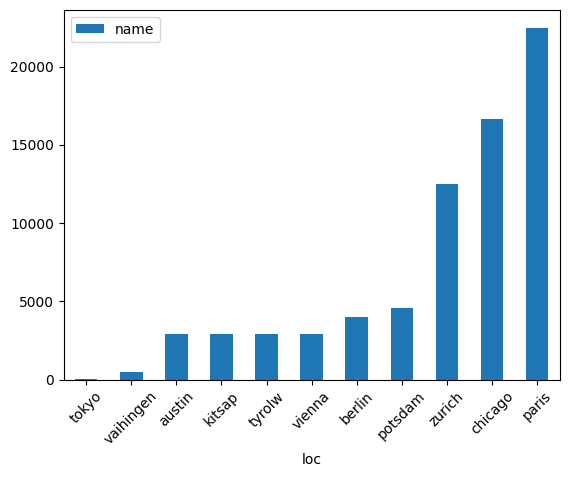

In [42]:
df = DataFrame({"name" : sorted([f.stem for f in TILED_IMAGE_DIR.iterdir()])})
df["loc"] = df["name"].apply(lambda x: keep_alpha(x))
df.groupby("loc").count().sort_values("name").plot(kind = "bar", rot=45);